These library calls are for:
- `cv2` which gives us a way of using Python wrapped C++ code for image manipulation.
- `numpy` which gives us a way of storing and handling matrices more efficiently in Python.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

this is just a test image import

In [2]:
fileName = "manuscripts/stvrnktmnstrygrkcllctnn.53/images/15_01_0053_0009_f_4v_res.png"
img = cv2.imread(fileName)
cv2.imwrite("temp/image53Stripe-Margin.jpg", img)

True

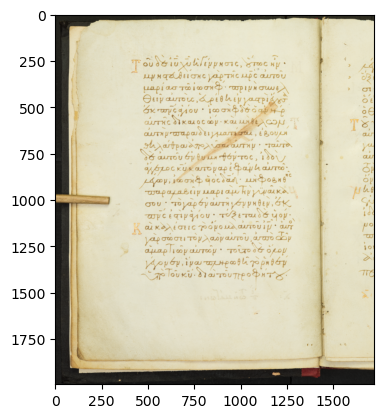

In [3]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# grayscale

Not much to say about this. This function takes in a colorized image and returns a grayscale image.

In [4]:
def grayscale(image):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return image

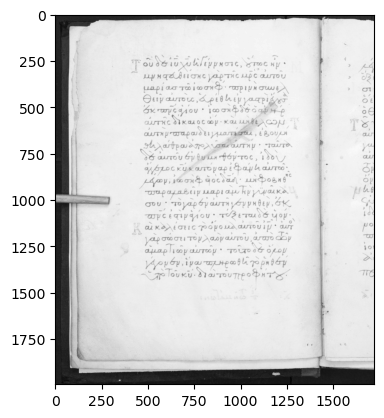

In [5]:
gray = grayscale(img)
plt.imshow(gray, cmap="gray")

# adaptBinarization

This function takes a greyscale image and returns a binarized version of it. This is to say that the pixel intensity values  of a given image may range between many of the 256 possible intensities that a computer monitor can output (more in specialized contexts, but that's another point for another time). This takes those images and assigns either the greatest intensity or the least intensity, but nothing in between, to any given pixel in the image.

This assignment is based on whether the individual pixel $P$ satisfies $P\leq T_G$ (that is, the pixel intensity is less than or equal to the threshold value) where $T_G=G*I-C$ where $G$ is a Gaussian kernel, $I$ is the image, $*$ is the 2D convolution operation, and $C$ is a constant to allow the user to have some control over the extent that thresholding impacts the outcome. Each of these paramaters can be tuned by a user, but the default values are well tested.

In [6]:
def adaptBinarization(image, kernelSize=25, constant=8):
    imageBinarized = cv2.adaptiveThreshold(
        image,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        kernelSize,
        constant,
    )
    normalizedBin = imageBinarized / 255
    return normalizedBin.astype(int)

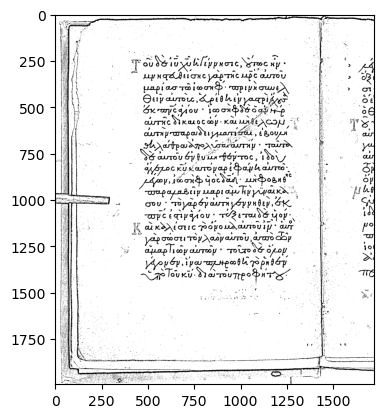

In [7]:
imgBin = adaptBinarization(gray, kernelSize=25, constant=8)
plt.imshow(imgBin, cmap="gray")

# invert

This takes an image and inverts the values of the pixel (turning dark pixels light and light pixels dark)

In [8]:
def invert(img):
    img = np.where(img == 1, 0, 1)
    return img

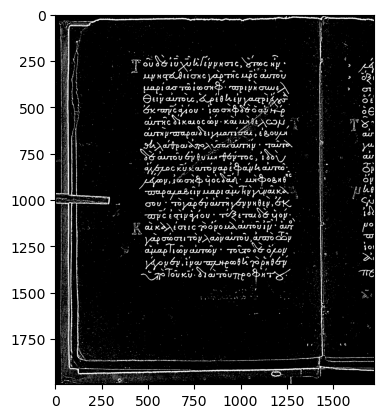

In [9]:
invertedBin = invert(imgBin)

plt.imshow(invertedBin, cmap="gray")

Note that, while this image is very clean to human eyes, there is a lot of ambiguity in it. Below is a histogram summing the values in each column of the image to show just how much extra 'noise' is still in the image.

<BarContainer object of 1722 artists>

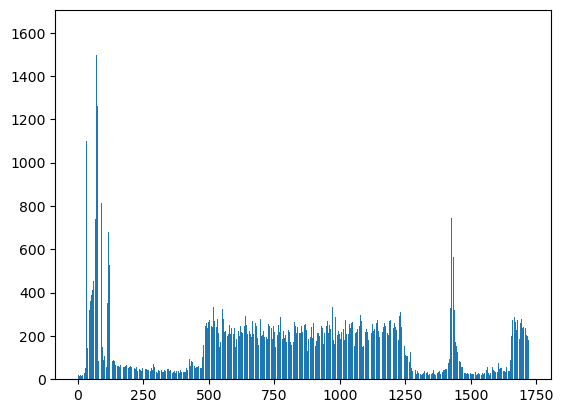

In [10]:
xInverted = invertedBin.sum(axis=0)
plt.bar(range(len(xInverted)), xInverted)

# floodFill

This function is an implementation of a well documented algorithm for identifying connected components in binarized images. For this version, the main core of the algorithm is taken from Burger and Burge's excellent text on *Digital Image Processing* (ch. 8). This uses the Breadth-First version of the algorithm. It is adapted for a couple of purposes.

In [11]:
def floodFill(img, coordinate, label, baseline=1):
    queue = [coordinate]
    while queue:
        (y, x) = queue.pop()
        inBounds = 0 <= y and y < img.shape[0] and 0 <= x and x < img.shape[1]
        if inBounds and img[y, x] == baseline:
            neighbors = [
                (y - 1, x - 1),
                (y, x - 1),
                (y + 1, x - 1),
                (y - 1, x),
                (y + 1, x),
                (y - 1, x + 1),
                (y, x + 1),
                (y + 1, x + 1),
            ]
            for i, j in neighbors:
                queue.append((i, j))
            img[y, x] = label

In [12]:
test = np.array(
    [
        [0, 0, 0, 0, 0],
        [0, 1, 2, 1, 0],
        [0, 1, 2, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0],
    ]
)

floodFill(test, (1, 1), 3)
print(test)

[[0 0 0 0 0]
 [0 3 2 3 0]
 [0 3 2 3 0]
 [0 3 3 3 0]
 [0 0 0 0 0]]


# regionLabel

This takes an image matrix of a binarized image and systematically fills every region.

In [13]:
def regionLabel(img):
    copy = np.zeros(img.shape) + img
    label = 2
    for (y, x), k in np.ndenumerate(copy):
        if k == 1:
            floodFill(copy, (y, x), label)
            label += 1
    copyDown = copy
    return copyDown.astype(int)

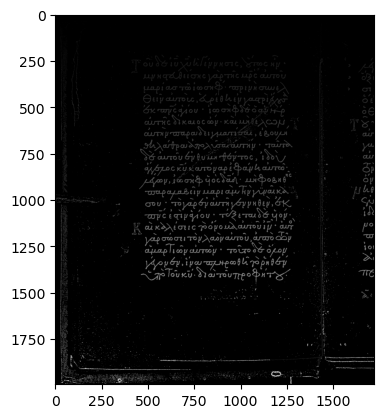

In [14]:
regLab = regionLabel(invertedBin)
plt.imshow(regLab, cmap="gray")

# regionSizes

Using the `boundingBox` function, this function will box all the regions in an image processed with regionLabel and return them in a list with the region label and the area of the bounding box surrounding the region.

In [15]:
def regionSizes(img):
    regionsNumber = np.amax(img)
    i = 2
    regionList = []
    while i <= regionsNumber:
        region = np.where(img == i, 1, 0)
        regionSize = region.sum()
        regionList.append((regionSize, i))
        i += 1
    return regionList

In [16]:
testRegSize = regionSizes(regLab)

# regionCull

This function takes an image that has been processed by regionSizes and will remove elements inside based on how large the bounding box is. Anything above or below specified thresholds will be removed. It also takes in the inverted, binarized image in order to make the

In [17]:
def regionCull(boxedRegionsList, regionLabeledImage, lowerBound=100, upperBound=15000):
    copy = np.zeros(regionLabeledImage.shape)
    # Checks for region sizes within threshold values
    for i in range(len(boxedRegionsList)):
        size, label = boxedRegionsList[i]
        if size >= lowerBound and size <= upperBound:
            copy = copy + np.where(regionLabeledImage == label, 1, 0)

    return copy.astype(int)

Now that we have regions sized up, we want to remove the smallest regions, those containing the small smudges, the crinkling, the dust, all the things of a manuscript that slowly impact its pages. However, we don't want to be overzealous and remove too much stuff. We want to keep characters. Below we have a distribution of the size of objects, you'll notice that there are a ton of incredibly small objects speckling the graph. This is the vast majority of what is on the manuscript. However, there are also some very large objects. The graph doesn't show it, but there are some objects that take up quite a large number of pixels. We want to remove the really large objects. The easiest thing to do is cut off all objects where the number of objects of the same size is very small.

In [18]:
regionStats = []
for i in range(len(testRegSize)):
    regionStats.append(testRegSize[i][0])

unique, counts = np.unique(regionStats, return_counts=True)

regionCounts = dict(zip(unique, counts))
print(max(regionCounts.values()))

3155


<BarContainer object of 379 artists>

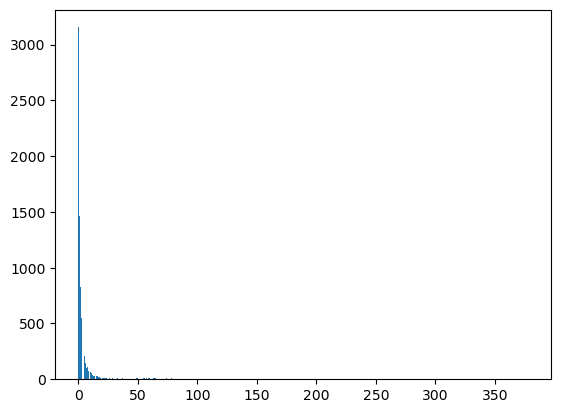

In [19]:
plt.bar(range(len(regionCounts)), list(regionCounts.values()), align="center")

# getRegionCounts

This function counts the number of regions of a particular size in our region sized image. It takes in a list of regions and their sizes and counts the sizes, irrespective of the particular region. It returns these values in a dictionary.

In [20]:
def getRegionCounts(regionsAndSizes):
    regionStats = []
    for i in range(len(regionsAndSizes)):
        regionStats.append(regionsAndSizes[i][0])

    unique, counts = np.unique(regionStats, return_counts=True)

    return dict(zip(unique, counts))

# getMinIndex

This function, focusing on the fact that the distribution is bimodal, searches for the first local minimum in the histogram. Once the index is found, it is returned. It takes in the output of `getRegionCounts`.

In [21]:
def getMinIndex(regionCounts):
    values = list(regionCounts.values())

    for i in range(len(values)):
        difference = values[i + 1] - values[i]
        if (
            difference > 0
            and min(values[i + 1], values[i + 2], values[i + 3]) == values[i + 1]
        ):
            minIndex = i + 1
            break

    return minIndex

# getMaxIndex

This function, trying to remove exceedingly large objects, takes in the data from `getRegionCounts` and finds the first index where the data left in the tail has an arithematic mean of the square root of 2. No particular reason to pick the square root. It just seemed like a good number.

In [22]:
def getMaxIndex(regionCounts):
    values = list(regionCounts.values())

    for i in range(len(values)):
        tail = values[i:]
        tailMean = np.mean(tail)
        if tailMean <= 1:
            oneIndex = i
            break

    tailSizes = list(regionCounts.keys())[oneIndex:]
    tailDifferences = tailSizes - np.mean(tailSizes)
    for j in range(len(tailSizes)):
        if tailDifferences[j] >= 0:
            positiveIndex = oneIndex + j
            break

    return positiveIndex

True

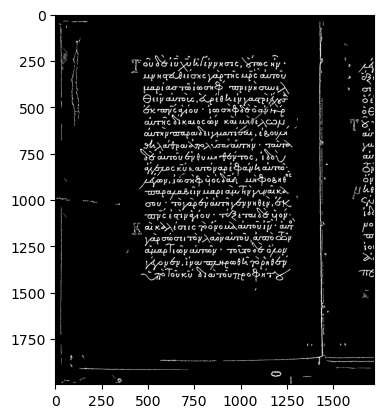

In [23]:
testRegCounts = getRegionCounts(testRegSize)
minCount = list(testRegCounts.keys())[getMinIndex(testRegCounts)]
maxCount = list(testRegCounts.keys())[getMaxIndex(testRegCounts)]

testRegionCull = regionCull(
    testRegSize, regLab, lowerBound=minCount, upperBound=maxCount
)

plt.imshow(testRegionCull, cmap="gray")

cv2.imwrite("temp/image53Stripe-Margin-Denoised.jpg", testRegionCull * 255)

# textIsolate

Now that we have mostly removed extra noise from the image, we want to take the text that we do have and isolate it from the rest of the image. While the text is fairly clear to the human eye, there are other distractions that can serve as difficulties to the OCR engine unless removed. We will utilize a 'histogram' approach to the problem. In essence, we take the sum along a particular row or column of the values in the row or column to generate a histogram.

<BarContainer object of 1722 artists>

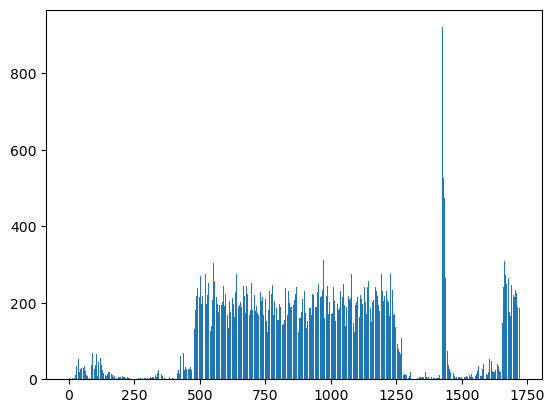

In [24]:
x = testRegionCull.sum(axis=0)
xRange = range(len(x))
plt.bar(xRange, x)

Notice how this compares to the previous histogram we had. The noise that was removed by the region culling process is pictured below.

<BarContainer object of 1722 artists>

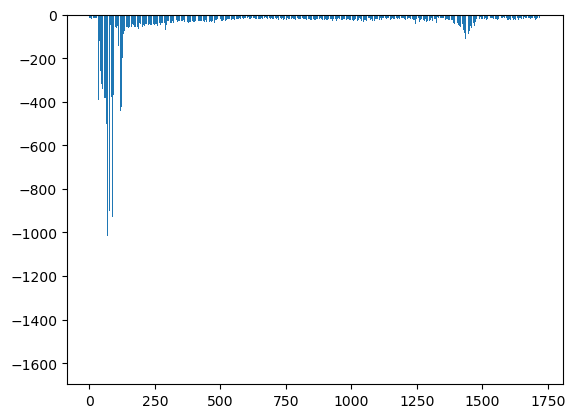

In [25]:
plt.bar(xRange, x - xInverted)

Now that we have a histogram, we want to be able to use it to extract the regions of text in an image. Notice that, the image has a lot of text in the center, which correlates to a large region on the histogram. However, some of the page edges, as well as text from other pages, is in play for this manuscript. Given the single column nature of this text, we can isolate the text column in the center with some mathematics. To do this, we will create 'bins' to smooth over some of the individual spikes. Then, we will see how the values in a bin compare to the average (arithmetic mean) of the histogram data.

$\text{column sum}-\text{average column value}$

The bins that have positive values in them after this process are regions of interest (for our application).

<BarContainer object of 87 artists>

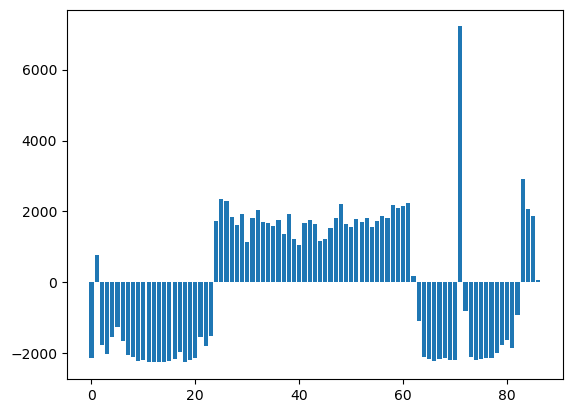

In [26]:
binNumber = int(len(x) / 20)
binSizeX = int(len(x) / binNumber)
xMean = np.mean(x)
bins = [0]
binIndex = 0
binCount = 0
binCutoff = binSizeX * binNumber
for i in range(binCutoff):
    binCount = (binCount + 1) % binSizeX
    if binCount == 0:
        bins.append(0)
        binIndex += 1

    bins[binIndex] += x[i] - xMean

plt.bar(range(len(bins)), bins)

Now, we take this histogram and identify the largest set of contiguous positive bins and that is what we identify as our region of interest. We have to be careful not to include bins beyond our boundaries. Also, given that the cutoffs might be a bit strict (that some text might be found in the bins directly to the left and right of our region of interest), we add a little buffer to our region sizing. Further, given the fact that the language is written from left to right, we have to be extra generous, assuming that some text on the left could be removed. So, we first identify the regions of positive bins.

In [27]:
posRegions = []
regionStart = 0
regionEnd = 0
for i in range(len(bins)):
    if bins[i] > 0:
        if i != 0:
            if bins[i - 1] <= 0:
                regionStart = i - 2
        if i != len(bins) - 1:
            if bins[i + 1] <= 0:
                regionEnd = i + 2
                posRegions.append((regionStart, regionEnd))
        # boundary cases
        if i == 0:
            if bins[i] > 0:
                regionStart = i
        if i == len(bins) - 1:
            if bins[i] > 0:
                regionEnd = i
                posRegions.append((regionStart, regionEnd))

Once we have regions of positive bins, we focus on finding the largest region in there and converting from our bin histogram back to the image coordinates.

In [28]:
maxRegionSize = 0
maxRegionIndex = 0
for i in range(len(posRegions)):
    regionSize = posRegions[i][1] - posRegions[i][0]
    if regionSize > maxRegionSize:
        maxRegionIndex = i
        maxRegionSize = regionSize

maxRegionIndices = (
    posRegions[maxRegionIndex][0] * binSizeX,
    posRegions[maxRegionIndex][1] * binSizeX,
)

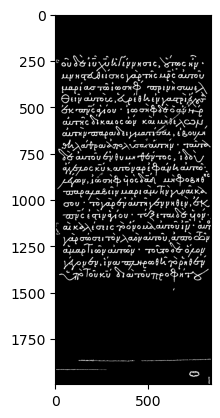

In [29]:
plt.imshow(testRegionCull[:, maxRegionIndices[0] : maxRegionIndices[1]], cmap="gray")

Now we create a function on two axes in order to isolate only the center text. It will take in a region culled image and output an image of just text (theoretically). It will also take in a bin number for fine tuning.

In [30]:
def textIsolate(regionCulledImage, columns=1):
    x = testRegionCull.sum(axis=0)
    y = testRegionCull.sum(axis=1)

    binNumberX = int(len(x) / 10)
    binSizeX = int(len(x) / binNumberX)
    xMean = np.mean(x)

    binNumberY = int(len(y) / 60)
    binSizeY = int(len(y) / binNumberY)
    yMean = np.mean(y)

    binIndex = 0
    binCount = 0

    xBins = [0]
    xBinCutoff = binSizeX * binNumberX

    for i in range(xBinCutoff):
        binCount = (binCount + 1) % binSizeX
        if binCount == 0:
            xBins.append(0)
            binIndex += 1
        xBins[binIndex] += (x[i] - xMean) / xMean

    binIndex = 0
    binCount = 0

    yBins = [0]
    yBinCutoff = binSizeY * binNumberY

    for i in range(yBinCutoff):
        binCount = (binCount + 1) % binSizeY
        if binCount == 0:
            yBins.append(0)
            binIndex += 1
        yBins[binIndex] += (y[i] - yMean) / yMean

    xPosRegions = []
    for i in range(len(xBins)):
        if xBins[i] > 0:
            # boundary cases
            if i == 0:
                if xBins[i] > 0:
                    regionStart = i
            if i == len(xBins) - 1:
                if xBins[i] > 0:
                    regionEnd = i
                    xPosRegions.append((regionStart, regionEnd))
            # interior cases
            if i != 0:
                if xBins[i - 1] <= 0:
                    regionStart = i - 4
            if i != len(xBins) - 1:
                if xBins[i + 1] <= 0:
                    regionEnd = i + 4
                    xPosRegions.append((regionStart, regionEnd))

    yPosRegions = []
    for i in range(len(yBins)):
        if yBins[i] > 0:
            # boundary cases
            if i == 0:
                if yBins[i] > 0:
                    regionStart = i
            if i == len(xBins) - 1:
                if yBins[i] > 0:
                    regionEnd = i
                    yPosRegions.append((regionStart, regionEnd))
            # interior cases
            if i != 0:
                if yBins[i - 1] <= 0:
                    regionStart = i - 1
            if i != len(yBins) - 1:
                if yBins[i + 1] <= 0:
                    regionEnd = i + 1
                    yPosRegions.append((regionStart, regionEnd))

    if columns == 1:
        xMaxRegionSize = 0
        xMaxRegionIndex = 0
        for i in range(len(xPosRegions)):
            regionSize = xPosRegions[i][1] - xPosRegions[i][0]
            if regionSize > xMaxRegionSize:
                xMaxRegionIndex = i
                xMaxRegionSize = regionSize
        xMaxRegionIndices = [
            xPosRegions[xMaxRegionIndex][0] * binSizeX,
            xPosRegions[xMaxRegionIndex][1] * binSizeX,
        ]
    else:
        for i in range(abs(columns - len(xPosRegions))):
            xMinRegionSize = xPosRegions[0][1] - xPosRegions[0][0]
            xMinRegionIndex = 0
            for j in range(len(xPosRegions)):
                regionSize = xPosRegions[j][1] - xPosRegions[j][0]
                if regionSize <= xMinRegionSize:
                    xMinRegionIndex = j
                    xMinRegionSize = regionSize
            xPosRegions = (
                xPosRegions[:xMinRegionIndex] + xPosRegions[xMinRegionIndex + 1 :]
            )

        xMaxRegionIndices = []
        for i in range(len(xPosRegions)):
            xMaxRegionIndices.append(
                [xPosRegions[i][0] * binSizeX, xPosRegions[i][1] * binSizeX]
            )

    yMaxRegionSize = 0
    yMaxRegionIndex = 0
    for i in range(len(yPosRegions)):
        regionSize = yPosRegions[i][1] - yPosRegions[i][0]
        if regionSize > yMaxRegionSize:
            yMaxRegionIndex = i
            yMaxRegionSize = regionSize

    yMaxRegionIndices = [
        yPosRegions[yMaxRegionIndex][0] * binSizeY,
        yPosRegions[yMaxRegionIndex][1] * binSizeY,
    ]

    return [yMaxRegionIndices, xMaxRegionIndices]

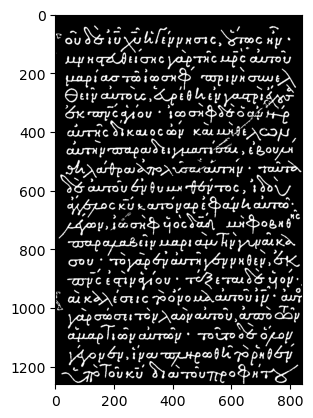

In [31]:
isolatedText = textIsolate(testRegionCull)

plt.imshow(
    testRegionCull[
        isolatedText[0][0] : isolatedText[0][1], isolatedText[1][0] : isolatedText[1][1]
    ],
    cmap="gray",
)

# rotateImage

Based on the [answer](https://stackoverflow.com/a/9042907) from Alex Rodrigues and Aemmi Sajjad, this will rotate an image about its center by a specified angle.

In [32]:
def rotateImage(image, angle):
    imageCenter = tuple(np.array(image.shape[1::-1]) / 2)
    rotationMatrix = cv2.getRotationMatrix2D(imageCenter, angle, 1.0)
    rotatedImage = cv2.warpAffine(
        image.astype(np.uint8),
        rotationMatrix,
        image.shape[1::-1],
        flags=cv2.INTER_LINEAR,
    )
    return rotatedImage.astype(int)

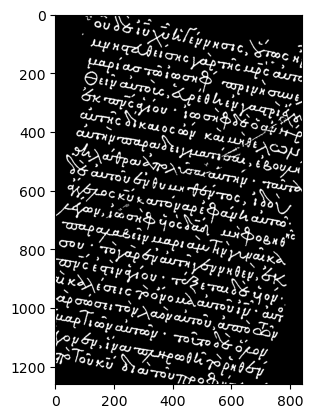

In [33]:
testRegion = testRegionCull[
    isolatedText[0][0] : isolatedText[0][1], isolatedText[1][0] : isolatedText[1][1]
]
rotatedImage = rotateImage(testRegion, -10)
plt.imshow(rotatedImage, cmap="gray")

# deskew

For this part of the problem, we deskew the image to try and make the lines perfectly horizontal. The best way to do this, that I know of, is to use a histogram approach. Consider the following histogram related to our image:

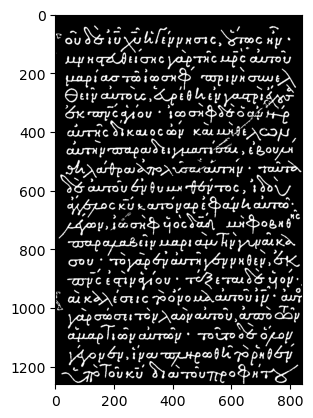

In [34]:
plt.imshow(testRegion, cmap="gray")

<BarContainer object of 1260 artists>

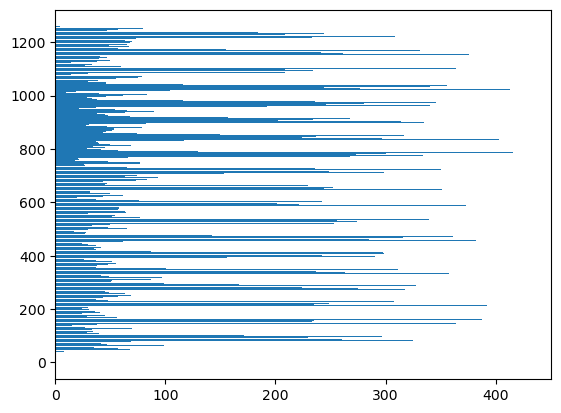

In [35]:
y = testRegion.sum(axis=1)
yRange = range(len(y))
plt.barh(yRange, y)

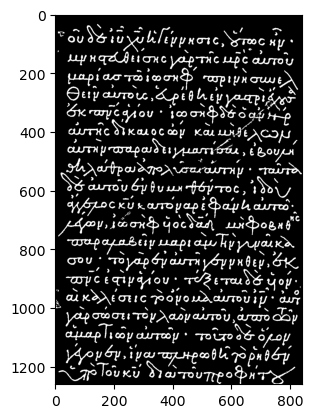

In [36]:
rotatedImage = rotateImage(testRegion, -1)
plt.imshow(rotatedImage, cmap="gray")

<BarContainer object of 1260 artists>

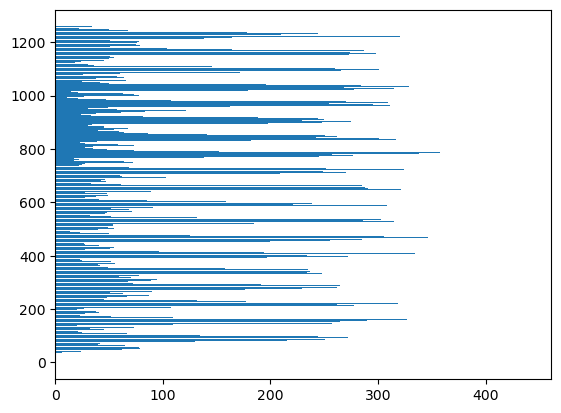

In [37]:
y2 = rotatedImage.sum(axis=1)
y2Range = range(len(y2))
plt.barh(y2Range, y2)

Notice that the spikes are 'spikier' in the rotated image. By straightening the image against the y-axis, this histogram has higher highs and lower lows. A good metric for this is the variance. Using the `var()` function of `numpy`, we can determine the variance of a particular histogram.

In [38]:
print(np.var(y))
print(np.var(y2))

13346.410226757369
10848.774474048878


Notice that `y2` has a greater variance than `y`. In the context of text alignment, this is a good metric to determine if an image is rotated appropriately. We can define the following function as a recursive approach to removing the skew of an image.

In [39]:
def deskew(image, angle=2, varianceLast=0):
    # This rotates an image counter-clockwise by the given angle
    imageUp = rotateImage(image, angle)
    # As before, but rotating it clockwise
    imageDown = rotateImage(image, -angle)

    varianceUp = np.var(imageUp.sum(axis=1))
    varianceDown = np.var(imageDown.sum(axis=1))

    if varianceDown < varianceUp:
        angle = angle
        varianceNow = varianceUp
        img = imageUp
    else:
        angle = -angle
        varianceNow = varianceDown
        img = imageDown

    if abs(varianceLast - varianceNow) < 10**-4:
        return img
    else:
        img = deskew(img, angle=angle / 2, varianceLast=varianceNow)
        return img.astype(int)

True

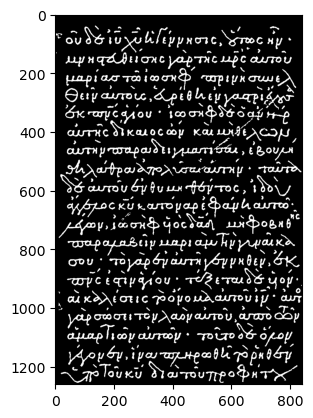

In [40]:
deskewedImage = deskew(testRegion)

plt.imshow(deskewedImage, cmap="gray")

cv2.imwrite("temp/image53Stripe-Margin-Deskewed.jpg", deskewedImage * 255)

14655.927563618037


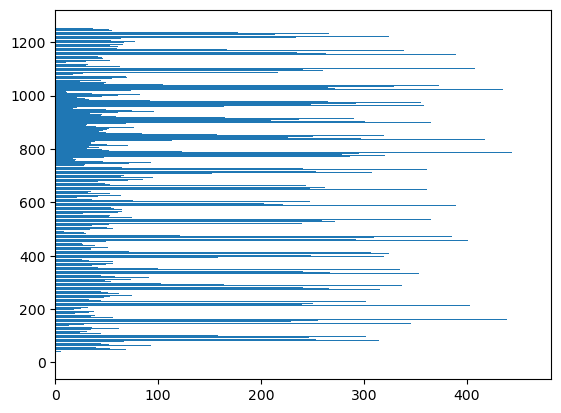

In [41]:
y = deskewedImage.sum(axis=1)
yRange = range(len(y))
plt.barh(yRange, y)
print(np.var(y))

Now, just as we zoomed in on columns of text from a larger mileiu, we can try to do the same here with identifying lines of text. We identify the positive regions from the following graph.

<BarContainer object of 127 artists>

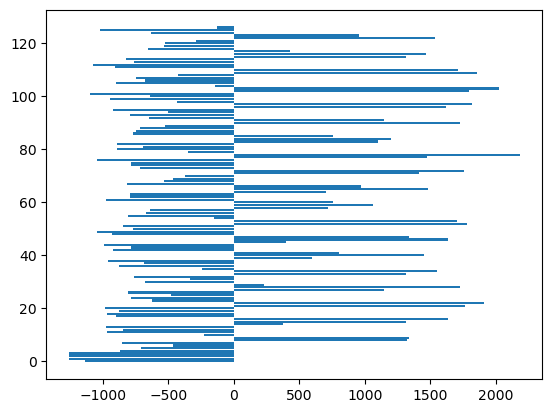

In [42]:
binNumberY = int(len(y) / 10)
binSizeY = int(len(y) / binNumberY)
yMean = np.mean(y)
yBins = [0]
binIndex = 0
binCount = 0
binCutoff = binSizeY * binNumberY
for i in range(binCutoff):
    binCount = (binCount + 1) % binSizeY
    if binCount == 0:
        yBins.append(0)
        binIndex += 1

    yBins[binIndex] += y[i] - yMean

plt.barh(range(len(yBins)), yBins)

Using the following code, we get the positive regions.

In [43]:
yPosRegions = []
for i in range(len(yBins)):
    if yBins[i] > 0:
        # boundary cases
        if i == 0:
            if yBins[i] > 0:
                regionStart = i
        if i == len(yBins) - 1:
            if yBins[i] > 0:
                regionEnd = i
                yPosRegions.append((regionStart, regionEnd))
        # interior cases
        if i != 0:
            if yBins[i - 1] <= 0:
                regionStart = i
        if i != len(yBins) - 1:
            if yBins[i + 1] <= 0:
                regionEnd = i
                yPosRegions.append((regionStart, regionEnd))

For the test manuscript, there are 19 lines, so this is the number of positive regions we are trying to find.

In [44]:
len(yPosRegions)

19

In [45]:
midLineIndices = []
maxLineIndices = []
for i in range(len(yPosRegions)):
    minY, maxY = yPosRegions[i]
    binsInRegion = maxY - minY
    largestIndex = minY
    for j in range(binsInRegion):
        if yBins[j + minY] >= yBins[largestIndex]:
            largestIndex = j + minY
    midLineIndices.append(int((largestIndex + 0.5) * binSizeY))
    maxLineIndices.append(maxY * binSizeY)

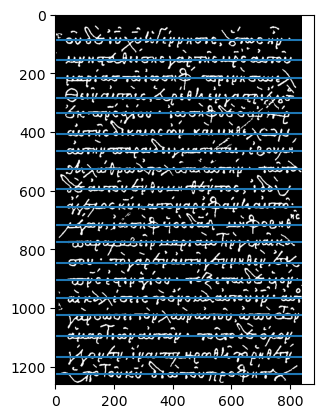

In [46]:
plt.imshow(deskewedImage, cmap="gray")

xmin, xmax = (0, deskewedImage.shape[1])

plt.hlines(midLineIndices, xmin, xmax)

These lines correlate pretty darn well with all the characters on a line. It's not quite perfect. There are some characters with a "lower" center of gravity. For especially exaggerated styles of writing. So, we keep the index of the final region as well.

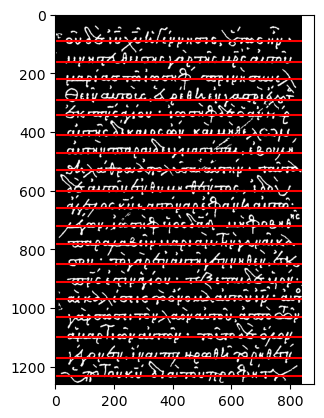

In [47]:
plt.imshow(deskewedImage, cmap="gray")

xmin, xmax = (0, deskewedImage.shape[1])

plt.hlines(maxLineIndices, xmin, xmax, color="r")

In [48]:
def getTextLineIndices(deskewedImage):
    binNumberY = int(len(y) / 10)
    binSizeY = int(len(y) / binNumberY)
    yMean = np.mean(y)
    yBins = [0]
    binIndex = 0
    binCount = 0
    binCutoff = binSizeY * binNumberY
    for i in range(binCutoff):
        binCount = (binCount + 1) % binSizeY
        if binCount == 0:
            yBins.append(0)
            binIndex += 1

        yBins[binIndex] += y[i] - yMean

    midLineIndices = []
    maxLineIndices = []
    for i in range(len(yPosRegions)):
        minY, maxY = yPosRegions[i]
        binsInRegion = maxY - minY
        largestIndex = minY
        for j in range(binsInRegion):
            if yBins[j + minY] >= yBins[largestIndex]:
                largestIndex = j + minY
        midLineIndices.append(int((largestIndex + 0.5) * binSizeY))
        maxLineIndices.append(maxY * binSizeY)

    return midLineIndices, maxLineIndices

Now that we have the lines, we just need to use the flood filling technique that we have used before to fill the components directly along the lines rather than in the whole image.

In [49]:
def lineFill(img, midIndices, maxIndices):
    copy = np.zeros(img.shape) + img
    label = 2
    for i in range(len(midIndices)):
        for (y, x), k in np.ndenumerate(copy[midLineIndices[i] : maxLineIndices[i], :]):
            if int(k) == 1:
                floodFill(copy, (y + midLineIndices[i], x), label)
        label += 1
        # Removing crossover between text lines
        if i < len(midIndices) - 1:
            for (y, x), k in np.ndenumerate(
                copy[midLineIndices[i + 1] : maxLineIndices[i + 1], :]
            ):
                if int(k) == label - 1:
                    midpoint = int((maxLineIndices[i] + midLineIndices[i + 1]) / 2)
                    for (y, x), k in np.ndenumerate(copy[midpoint : midpoint + 1, :]):
                        if int(k) == label - 1:
                            img[y + midpoint, x] = 0
                    copy[midpoint : midpoint + 1, :] = np.where(
                        copy[midpoint : midpoint + 1, :] == 1, 1, 0
                    )
                    for (y, x), k in np.ndenumerate(
                        copy[midLineIndices[i + 1] : maxLineIndices[i + 1], :]
                    ):
                        if int(k) == label - 1:
                            floodFill(
                                copy,
                                (y + midLineIndices[i + 1], x),
                                label,
                                baseline=label - 1,
                            )
    copyDown = copy
    return copyDown.astype(int)

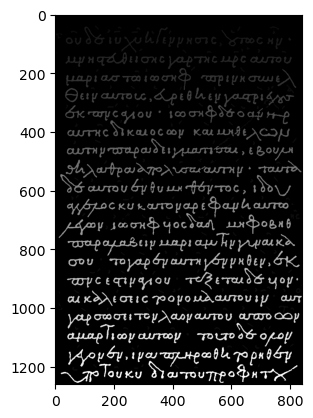

In [50]:
midIndices, maxIndices = getTextLineIndices(deskewedImage)

lineFilledImage = lineFill(deskewedImage, midIndices, maxIndices)

plt.imshow(lineFilledImage, cmap="gray")
# plt.imshow(np.where(lineFilledImage == 12, 1, 0),cmap='gray')
# plt.hlines([457,952,1597],xmin,xmax,color='r')

# underline

This function takes in an image from `lineFilledImage` as well as the original image with line indices and underlines every character and text line in that image. The underlining is performed on the original image with a label of 2.

In [51]:
def underline(lineFilledImage, maxLineIndices):
    greatestLabel = np.amax(lineFilledImage)
    underlines = np.zeros(lineFilledImage.shape)
    xLength = lineFilledImage.shape[1]
    for i in range(len(maxLineIndices)):
        label = i + 2
        greatestLabel += 1
        segmentationCopy = np.where(lineFilledImage == label, 1, 0)
        segmentationLine = (np.zeros(xLength) + maxLineIndices[i]).astype(int)
        for j in range(xLength):
            while segmentationCopy[segmentationLine[j] :, j].sum(axis=0) != 0:
                segmentationLine[j] += 1
            underlines[segmentationLine[j], j] = greatestLabel
    return underlines

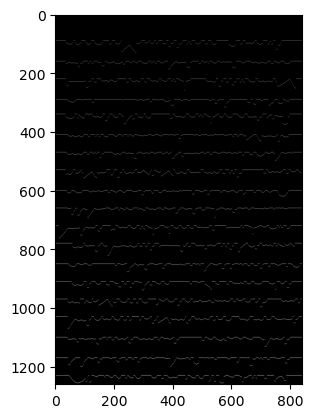

In [52]:
underlinedImage = underline(lineFilledImage, maxLineIndices)

plt.imshow(underlinedImage, cmap="gray")

In [53]:
def regionMasks(underlinedImage):
    masks = np.zeros(underlinedImage.shape)
    numberOfMasks = int((np.amax(underlinedImage) - 1) / 2)
    firstUnderlineNumber = (
        np.amax(underlinedImage) - numberOfMasks + 1
    )  # the +1 because of the original labeling scheme
    yLength, xLength = underlinedImage.shape

    for x in range(xLength):
        underlineNumber = firstUnderlineNumber
        for y in range(yLength):
            if underlinedImage[y][x] == underlineNumber:
                underlineNumber += 1
            masks[y][x] = underlineNumber

    return masks

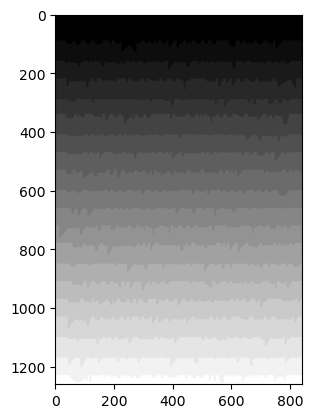

In [54]:
masks = regionMasks(underlinedImage)

plt.imshow(masks, cmap="gray")

In [55]:
def textLineSegment(masks, deskewedImage, maskNumber):
    yLength, xLength = deskewedImage.shape
    maskCopy = np.where(masks == maskNumber, 1, 0)
    textLine = np.multiply(deskewedImage, maskCopy)
    topBound = 0
    y = topBound
    while textLine.sum(axis=1)[y] == 0:
        y += 1
    topBound = y
    bottomBound = yLength - 1
    y = bottomBound - 1
    while textLine.sum(axis=1)[y] == 0:
        y += -1
    bottomBound = y
    return textLine[topBound:bottomBound, :]

In [56]:
def fullLineSegmentation(masks, deskewedImage):
    numberOfMasks = int(np.amax(masks) - np.amin(masks))
    extractedLines = []
    for i in range(numberOfMasks):
        maskNumber = np.amin(masks) + i
        extractedLines.append(textLineSegment(masks, deskewedImage, maskNumber))

    return extractedLines

In [57]:
segmentedLines = fullLineSegmentation(masks, deskewedImage)

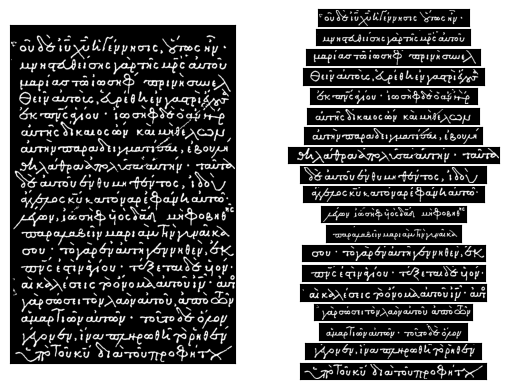

In [58]:
fig, axs = plt.subplots(len(segmentedLines), 2)

gs = axs[0, 1].get_gridspec()

for ax in axs[0:, 0]:
    ax.remove()
axbig = fig.add_subplot(gs[0:, 0])
axbig.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
axbig.imshow(deskewedImage, cmap="gray")

for i in range(len(segmentedLines)):
    axs[i][1].imshow(segmentedLines[i], cmap="gray")
    axs[i][1].tick_params(
        left=False, right=False, labelleft=False, labelbottom=False, bottom=False
    )

plt.savefig("temp/image53Stripe-Margin-Segmented.jpg")